# Jack’s Car Rental

---
A solution to Jack's car rental problem

In [1]:
import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from jax import random
from tensorflow_probability.substrates import jax as tfp

I1202 07:16:37.688233  354416 tpu_initializer_helper.cc:94] libtpu.so already in use by another process. Not attempting to load libtpu.so in this process.


In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

jnp.set_printoptions(suppress=True, linewidth=100)

In [3]:
# Discount rate
γ = 0.9
# Rate of request
λ_req_a, λ_req_b = 3, 4
# Rate of return
λ_ret_a, λ_ret_b = 3, 2

# Maximum number of cars allowed at any location
max_cars = 20
# Maximum number of cars that are allowed to be moved overnight
max_car_move = 5

# MDP:
# timestep: days
# state: number of cars at each location at the end of the day
# actions: net number of cars moved between the two locations overnight

To solve this problem, we must first determine the grid of possible values given by

$$
    p(s'_a, s'_b, r \vert s_a, s_b, a)
$$

* $\mathcal A = \{-5, -4, \ldots, 5\}$
* $\mathcal R = \left\{10, -2n\right\}$, where $n$ is the number of cars moved overnight

## Some experiments

In [4]:
S_a, S_b  = 10, 20

In [5]:
key = random.PRNGKey(314)

key_ret_a, key_req_a, key_ret_b, key_req_b = random.split(key, 4)

n_days = 500

returned_a = random.poisson(key_ret_a, λ_ret_a, (n_days,))
requested_a = random.poisson(key_req_a, λ_req_a, (n_days,))

returned_b = random.poisson(key_ret_b, λ_ret_b, (n_days,))
requested_b = random.poisson(key_req_b, λ_req_b, (n_days,))

In [6]:
def reduce_hist(state, xs):
    new_state = jnp.clip(state + xs, 0, 20)
    return new_state, new_state

### Inventory simulation

Assuming that there is no interaction between locations `a` and `b`, the following plot shows a simulation on the number of cars at each location at the end of the day.

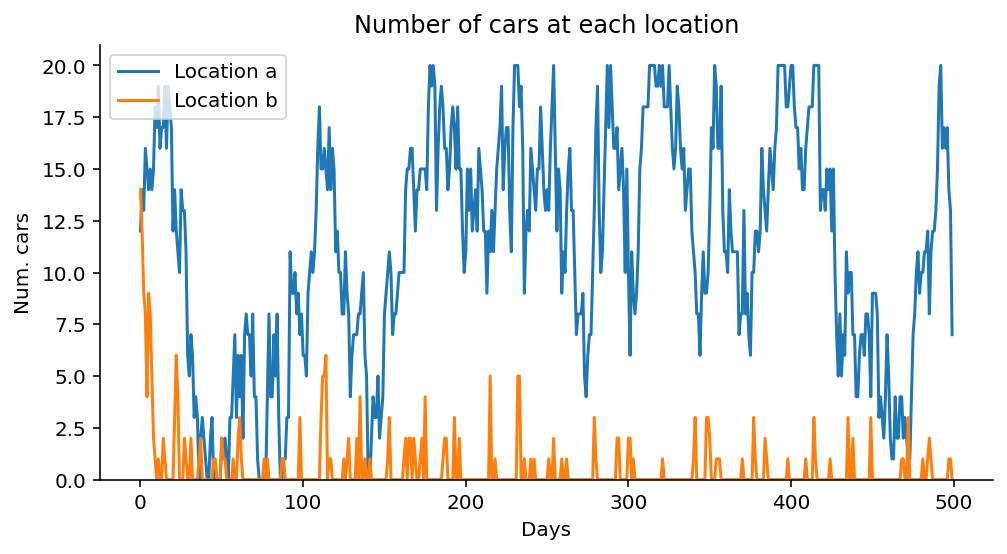

In [7]:
Δa = returned_a - requested_a
Δb = returned_b - requested_b

_, hist_a = jax.lax.scan(reduce_hist, S_a, Δa)
_, hist_b = jax.lax.scan(reduce_hist, S_b, Δb)

plt.subplots(1, 1, figsize=(8, 4))
plt.plot(hist_a, label="Location a")
plt.plot(hist_b, label="Location b")
plt.ylim(0, 21)
plt.legend()
plt.ylabel("Num. cars")
plt.xlabel("Days")
plt.title("Number of cars at each location");

## Computing probabilities

The claim is that

$$
    p(s_b' \vert s_b, a) = \text{Skellam}\left(s_b' - s_b -  a \vert \lambda_b^\text{ret}, \lambda_b^\text{req}\right) \mathbb{1}\big(0 \leq s_b' \leq 20\big)
$$

In [8]:
def prob_a(sa_prime, sa, action):
    dist = tfp.distributions.Skellam(λ_ret_a, λ_req_a)
    return dist.prob(sa_prime - sa - action) * (0 <= sa_prime) * (sa_prime <= 20)

In [9]:
sa = 3
a = 5

sa_prime_samp = sa + a + returned_a - requested_a
sa_prime_samp = (sa + a + returned_a - requested_a) * (0 <= sa_prime_samp) * (sa_prime_samp <= 20)

Computing the distribution of the number of cars at location `a` at the end of the day assuming that $s_a = 3$ and $a = 5$

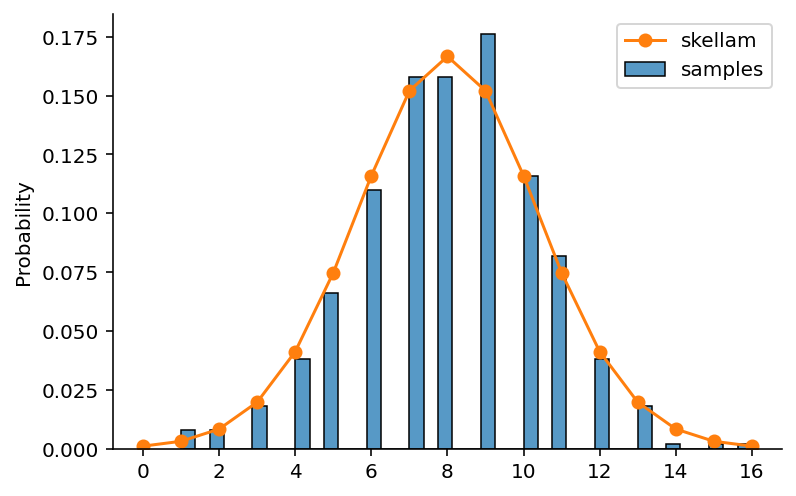

In [10]:
net_move_a = jnp.arange(0, 17).astype(float)

sns.histplot(sa_prime_samp, stat="probability", bins=40, label="samples")
plt.plot(net_move_a, prob_a(net_move_a, sa, a), c="tab:orange", marker="o", label="skellam")
plt.legend();

In [11]:
def prob_a(sa_prime, sa, action):
    """
    Probabiliy of moving `action` cars from location a -> location b
    """
    dist = tfp.distributions.Skellam(λ_ret_a, λ_req_a)
    return dist.prob(sa_prime - sa - action) * (0 <= sa_prime) * (sa_prime <= 20)

def prob_b(sb_prime, sb, action):
    """
    Probabiliy of moving `action` cars from location b -> location a
    """
    dist = tfp.distributions.Skellam(λ_ret_b, λ_req_b)
    return dist.prob(sb_prime - sb + action) * (0 <= sb_prime) * (sb_prime <= 20)

def p_move(action, sa, sb):
    return (sa >= action) * (sb >= -action)

In [12]:
sa = 1
sb = 0

actions = jnp.arange(-5, 6)
actions

DeviceArray([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5], dtype=int32)

In [13]:
for action in actions:
    val = p_move(action, sa, sb)
    print(f"{action:2}: {val}")

-5: False
-4: False
-3: False
-2: False
-1: False
 0: True
 1: True
 2: False
 3: False
 4: False
 5: False


In [14]:
arange = jnp.arange(-5, 6).astype(float)
vrange = jnp.arange(0, 21).astype(float)
req_range = jnp.arange(0, 40).astype(float)

$$
    p(s_a', s_b', n \vert s_a, s_b, a) = \text{Skellam}(s_a' - s_a + a \vert \lambda^\text{ret}_a, \lambda^\text{req}_a) \times \text{Skellam}(s_b' - s_b - a \vert \lambda^\text{ret}_b, \lambda^\text{req}_b)
\times \text{pois}\left((n + 2a)/10, \lambda^\text{req}_a + \lambda^\text{req}_b\right)
$$

In [47]:
def p_transition_a(state_prime, state, action):
    dist = tfp.distributions.Skellam(λ_ret_a, λ_req_a)
    return dist.prob(state_prime - state + action) * (0 >= state_prime) * (state_prime <= 20)


def p_transition_b(state_prime, state, action):
    dist = tfp.distributions.Skellam(λ_ret_b, λ_req_b)
    return dist.prob(state_prime - state - action) * (0 >= state_prime) * (state_prime <= 20)

def p_move(action, sa, sb):
    return (sa >= action) * (sb >= -action)

@jax.jit
def p(sa_prime, sb_prime, n_req, sa, sb, action):
    pois = tfp.distributions.Poisson(rate=λ_req_a + λ_req_b)
    prob_req = pois.prob(n_req) * (sa + sb >= n_req)
    return (p_transition_a(sa_prime, sa, action) * p_transition_b(sb_prime, sb, action) *
            prob_req * p_move(action, sa, sb))

In [48]:
arange

DeviceArray([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.], dtype=float32)

In [49]:
vrange

DeviceArray([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.,
             17., 18., 19., 20.], dtype=float32)

In [50]:
pv = jax.vmap(p,  (0,    None, None, None, None, None), out_axes=-1)
pv = jax.vmap(pv, (None, 0   , None, None, None, None), out_axes=-1)
pv = jax.vmap(pv, (None, None, 0   , None, None, None), out_axes=-1)
pv = jax.vmap(pv, (None, None, None, 0   , None, None), out_axes=-1)
pv = jax.vmap(pv, (None, None, None, None, 0   , None), out_axes=-1)
pv = jax.vmap(pv, (None, None, None, None, None, 0   ), out_axes=-1)


# sa', sb', n, sa, sb, action
p_grid = pv(vrange, vrange, req_range, vrange, vrange, arange)
# p_grid = p_grid / p_grid.sum(axis=0, keepdims=True).sum(axis=1, keepdims=True).sum(axis=2, keepdims=True)

In [51]:
array_reward =  10 * req_range[:, None] - 2 * arange[None, :]
# n, action
array_reward.shape

(40, 11)

In [52]:
value_array = jnp.zeros((21, 21))
# sa', sb'
value_array.shape

(21, 21)

In [53]:
reward_value = array_reward[None, None, ...] + γ * value_array[..., None, None]
# sa', sb', n, action
reward_value.shape

(21, 21, 40, 11)

In [54]:
# ** Initial policy **
# In the initial policy we assume that we will not be moving
# cars between lots
policy = jnp.zeros((11, 21, 21)) # (action, sa, sb)
policy = policy.at[5].set(1)

# ** Initial value function **
value_array = jnp.zeros((21, 21))

Indices' naming
```
a: sa
b: sb
c: action
i: sa'
j: sb'
k: n
```

In [55]:
reward_value = array_reward[None, None, ...] + γ * value_array[..., None, None]
for _ in range(20):
    value_array = jnp.einsum("cab,ijkabc,ijkc->ab", policy, p_grid, reward_value)

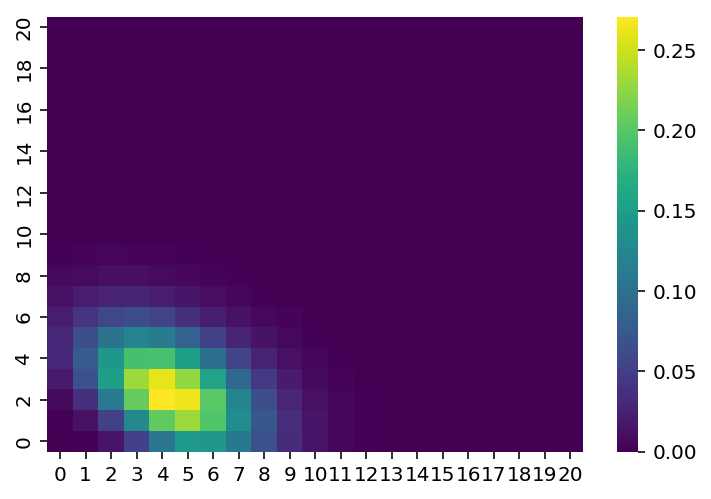

In [56]:
ax = sns.heatmap(value_array, cmap="viridis")
ax.invert_yaxis()

## Policy improvement

$$
    v_{\pi'}(s_a, s_b) = \max_a \sum_{s_a', s_b', n} p(s_a', s_b', n_\text{req} \vert s_a, s_b, a)\left[10n_\text{req} - 2a + v_\pi(s_a', s_b')\right]
$$

In [57]:
q_improv = jnp.einsum("ijkabc,ijkc->cab", p_grid, reward_value)

In [58]:
# Update value function
value_array = q_improv.max(axis=0)

# Policy improvment
policy = jnp.zeros((11, 21, 21))
policy = jax.nn.one_hot(q_improv.argmax(axis=0), 11, axis=0)

In [59]:
q_improv.argmax(axis=0) - 5

DeviceArray([[-5,  0,  0, -1, -1, -2, -2, -3, -3, -3, -4, -4, -5, -5, -5, -5, -5, -5, -5, -5, -5],
             [ 1,  1,  0,  0, -1, -1, -2, -2, -2, -3, -3, -4, -4, -5, -5, -5, -5, -5, -5, -5, -5],
             [ 2,  1,  1,  0,  0, -1, -1, -1, -2, -2, -3, -3, -4, -4, -5, -5, -5, -5, -5, -5, -5],
             [ 2,  2,  1,  1,  0,  0,  0, -1, -1, -2, -2, -3, -3, -4, -4, -5, -5, -5, -5, -5, -5],
             [ 3,  2,  2,  1,  1,  1,  0,  0, -1, -1, -2, -2, -3, -3, -4, -4, -4, -5, -5, -5, -5],
             [ 3,  3,  2,  2,  1,  1,  1,  0,  0, -1, -1, -2, -2, -3, -3, -3, -4, -4, -5, -5, -5],
             [ 4,  3,  3,  2,  2,  2,  1,  1,  0,  0, -1, -1, -2, -2, -2, -3, -3, -4, -4, -5, -5],
             [ 4,  4,  3,  3,  3,  2,  2,  1,  1,  0,  0, -1, -1, -1, -2, -2, -3, -3, -4, -4, -4],
             [ 5,  4,  4,  4,  3,  3,  2,  2,  1,  1,  0,  0,  0, -1, -1, -2, -2, -3, -3, -4, -4],
             [ 5,  5,  5,  4,  4,  3,  3,  2,  2,  1,  1,  1,  0,  0, -1, -1, -2, -2, -3, -3, -3],
          

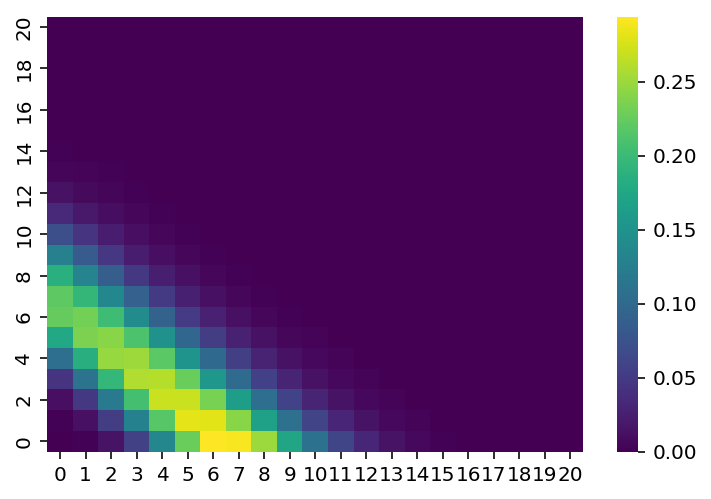

In [44]:
ax = sns.heatmap(value_array, cmap="viridis")
ax.invert_yaxis()